## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [5]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

def get_camcal_parameters():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        print(fname)
        img = cv2.imread(fname)
        #print(img)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        print(ret)
        #plt.imshow(img)
        #plt.show()
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imshow('img',img)

            cv2.waitKey(500)

    cv2.destroyAllWindows()
    return objpoints,imgpoints

In [6]:
import matplotlib.image as mpimg

def undistort_img(img,objpoints,imgpoints):
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #img=img[:,:,-1]
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=30)
    #ax2.imshow(dst)
    #ax2.set_title('Undistorted Image', fontsize=30)
    #plt.show()
    return dst


## Apply a distortion correction to raw images.

In [7]:
objpoints, imgpoints=get_camcal_parameters()


camera_cal/calibration1.jpg
False
camera_cal/calibration10.jpg
True
camera_cal/calibration11.jpg
True
camera_cal/calibration12.jpg
True
camera_cal/calibration13.jpg
True
camera_cal/calibration14.jpg
True
camera_cal/calibration15.jpg
True
camera_cal/calibration16.jpg
True
camera_cal/calibration17.jpg
True
camera_cal/calibration18.jpg
True
camera_cal/calibration19.jpg
True
camera_cal/calibration2.jpg
True
camera_cal/calibration20.jpg
True
camera_cal/calibration3.jpg
True
camera_cal/calibration4.jpg
False
camera_cal/calibration5.jpg
False
camera_cal/calibration6.jpg
True
camera_cal/calibration7.jpg
True
camera_cal/calibration8.jpg
True
camera_cal/calibration9.jpg
True


In [8]:
img = mpimg.imread('camera_cal/calibration1.jpg')
undist=undistort_img(img,objpoints,imgpoints)


In [9]:
distorted_images = glob.glob('test_images/*.jpg')
for filename in distorted_images:
    print(filename)
    img = mpimg.imread(filename)
    undist=undistort_img(img,objpoints,imgpoints)

test_images/straight_lines1.jpg
test_images/straight_lines2.jpg
test_images/test1.jpg
test_images/test2.jpg
test_images/test3.jpg
test_images/test4.jpg
test_images/test5.jpg
test_images/test6.jpg


## Use color transforms, gradients, etc., to create a thresholded binary image.

In [10]:

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    

test_images/straight_lines1.jpg


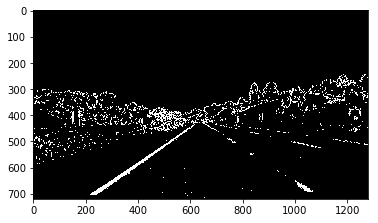

test_images/straight_lines2.jpg


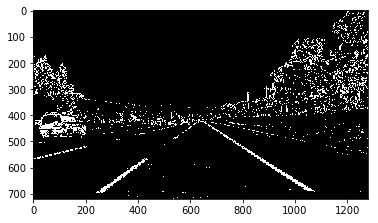

test_images/test1.jpg


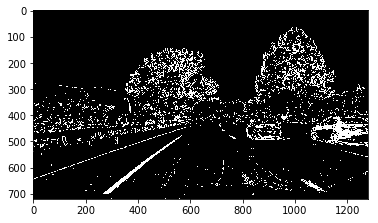

test_images/test2.jpg


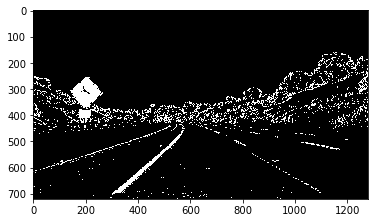

test_images/test3.jpg


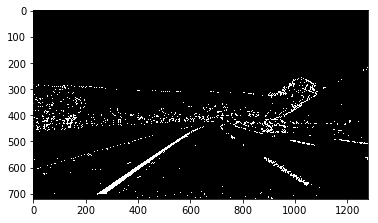

test_images/test4.jpg


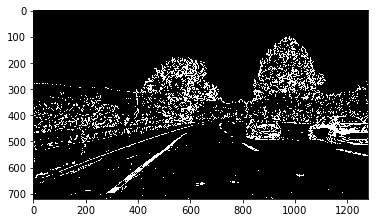

test_images/test5.jpg


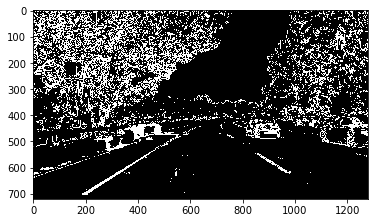

test_images/test6.jpg


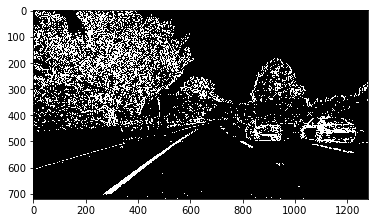

In [11]:
distorted_images = glob.glob('test_images/*.jpg')
for filename in distorted_images:
    print(filename)

    img = mpimg.imread(filename)
    undist=undistort_img(img,objpoints,imgpoints)
    bin_img=pipeline(undist)
    plt.imshow(bin_img,cmap='gray')
    plt.show()

## Apply a perspective transform to rectify binary image ("birds-eye view"). 

In [12]:
def convert_bird_view(img):
    src= np.float32([[260,684],[609,441],[667,441],[1035,677]])
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[303, 660],
                      [562, 472],
                      [725, 472],
                      [1003, 660]])

    offset=100
    dst = np.float32([[offset, img_size[1]-offset],
                     [offset, offset],
                     [img_size[0] - offset, offset],
                     [img_size[0] - offset, img_size[1]-offset ]])
    image=img
    src = np.float32(
          [[image.shape[1]/2-411,600],
           [image.shape[1]/2+411,600],
           [1280 -100               ,666],
           [0    +100               ,666]])
    
    dst = np.float32(
          [[image.shape[1]*0  ,image.shape[0]*0.9],
           [image.shape[1]*1  ,image.shape[0]*0.9],
           [image.shape[1]*1  ,image.shape[0]*1  ],
           [image.shape[1]*0  ,image.shape[0]*1  ]])

    #src=np.float32([[375,479],[905,479],[1811,685],[-531,685]])
    #dst=np.float32([[0,0],[500,0],[500,600],[0,600]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    MInv = cv2.getPerspectiveTransform(dst, src)
    return M,MInv

def perspective_transform(img,M):
    img_size=(img.shape[1],img.shape[0])
    warped_img = cv2.warpPerspective(img, M, img_size)
    return warped_img

def deperspective_transform(warped_img,MInv):
    img_size=(img.shape[1],img.shape[0])
    warped_img_inv = cv2.warpPerspective(warped_img, MInv, img_size)
    return warped_img_inv





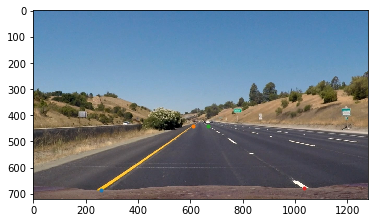

In [13]:
straight_line1_img=mpimg.imread('test_images/straight_lines1.jpg')                 
plt.imshow(straight_line1_img)
#plt.imshow(img)
plt.plot(260,684,'.')
plt.plot(609,441,'.')
plt.plot(667,441,'.')
plt.plot(1035,677,'.')
plt.show()


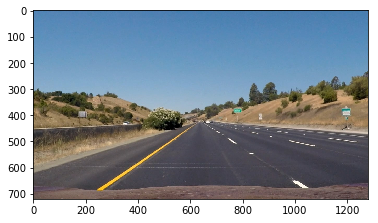

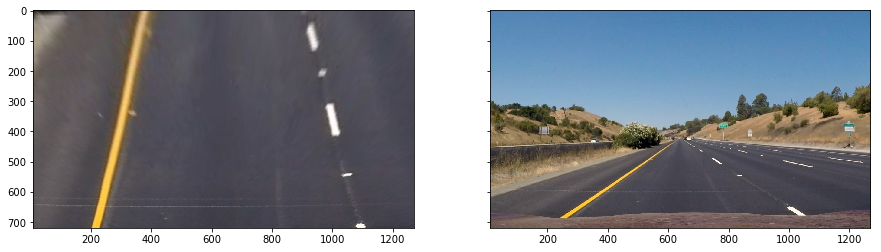

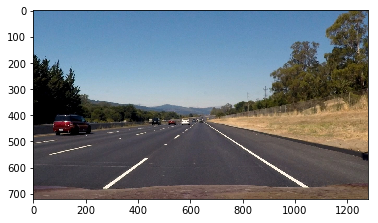

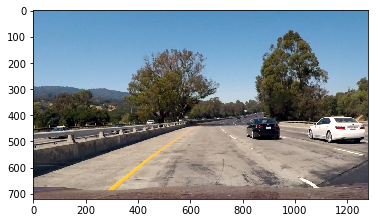

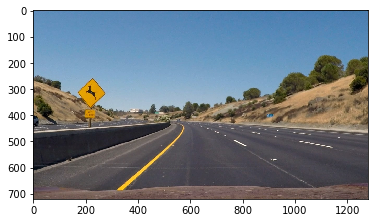

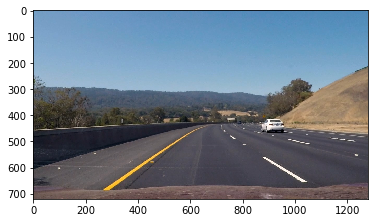

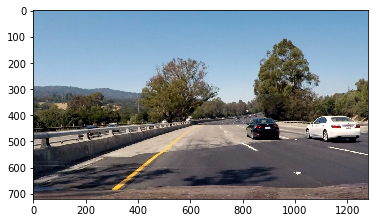

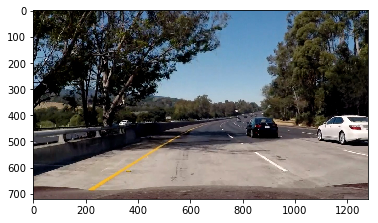

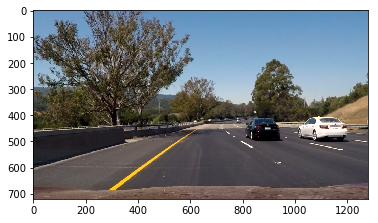

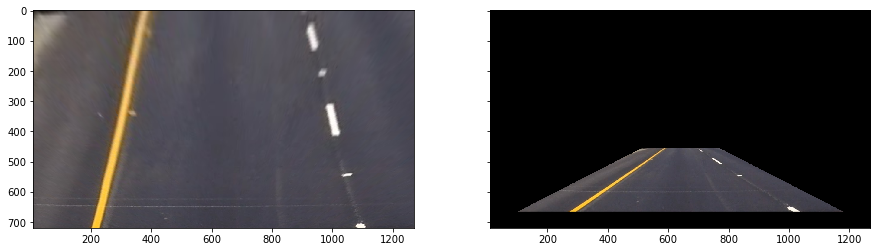

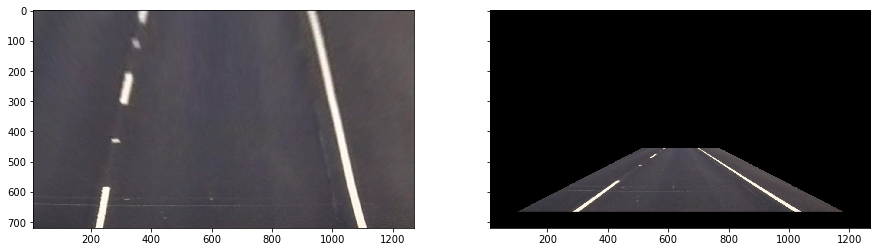

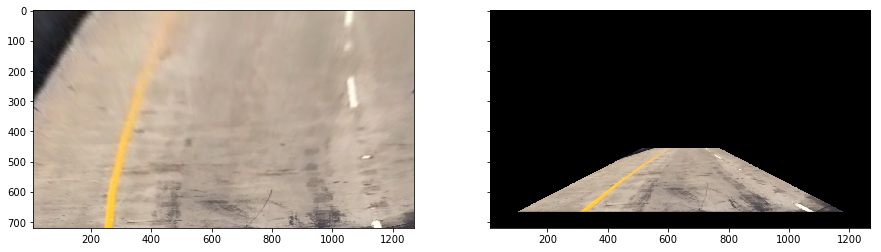

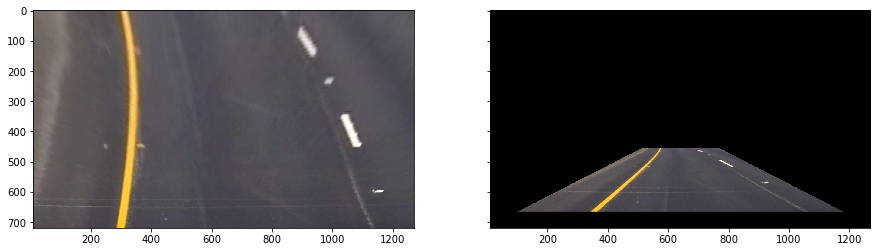

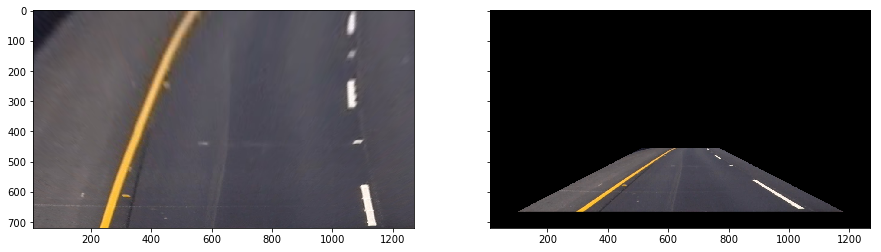

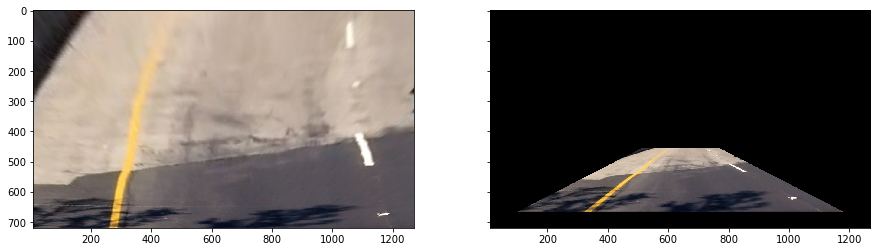

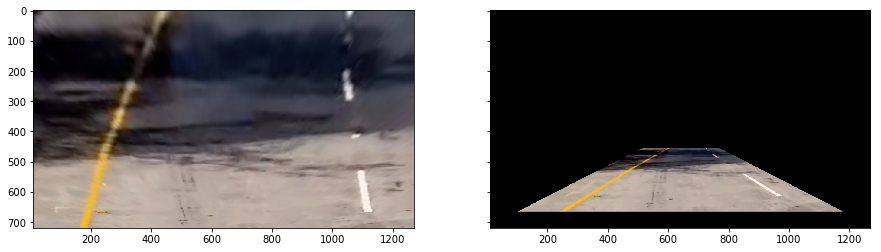

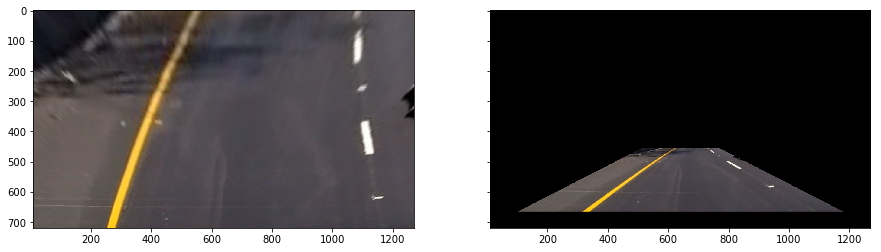

In [14]:
M,MInv=convert_bird_view(straight_line1_img)

straight_lines_1_warp = perspective_transform(straight_line1_img,M)
straight_lines_1_warp_inv = deperspective_transform(straight_lines_1_warp,MInv)

plt.imshow(straight_line1_img)
plt.show()

f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
f.set_size_inches([15., 4.])
ax1.imshow(straight_lines_1_warp)
ax2.imshow(straight_lines_1_warp_inv)


test_images = glob.glob('test_images/*.jpg')
for filenmae in test_images:
    img=mpimg.imread(filenmae)    
    plt.imshow(img)
    plt.show()
    
for filenmae in test_images:
    img=mpimg.imread(filenmae)    
    img_warp = perspective_transform(img,M)
    img_warp_inv = perspective_transform(img_warp,MInv)

    f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches([15., 4.])
    ax1.imshow(img_warp)
    ax2.imshow(img_warp_inv)
    


#  Detect lane pixels and fit to find the lane boundary.

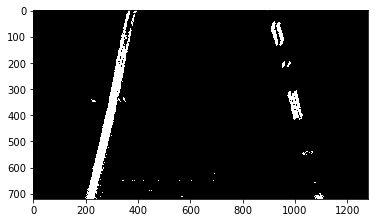

In [15]:

binary_image=pipeline(straight_lines_1_warp)
plt.imshow(binary_image,cmap='gray')
plt.show()

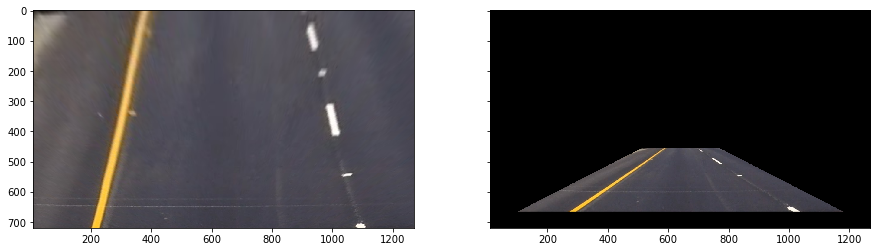

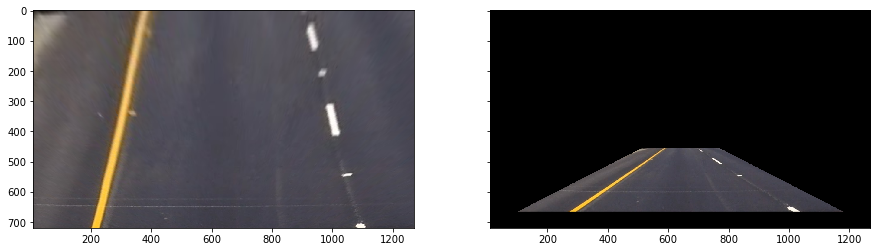

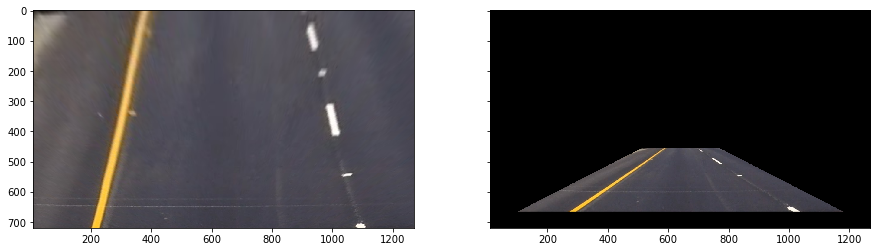

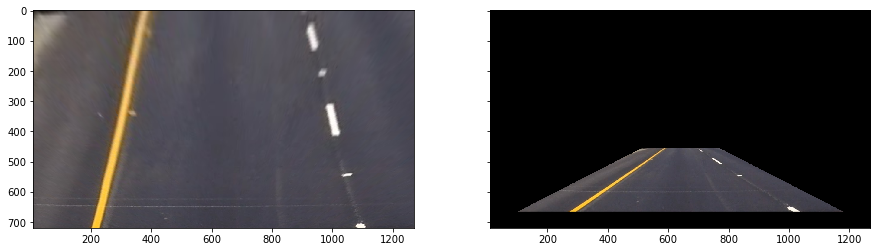

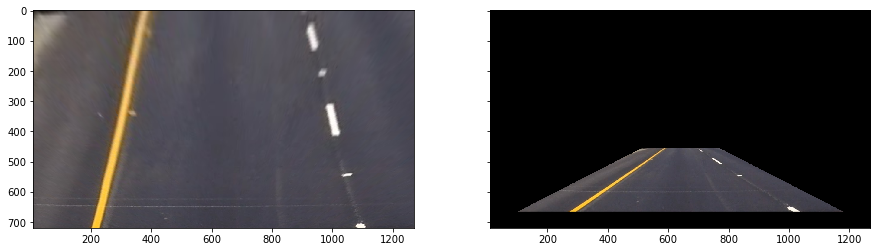

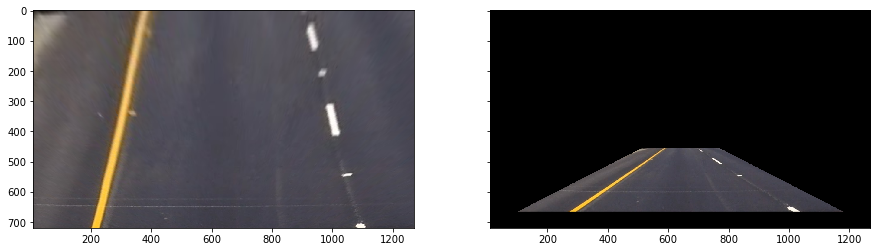

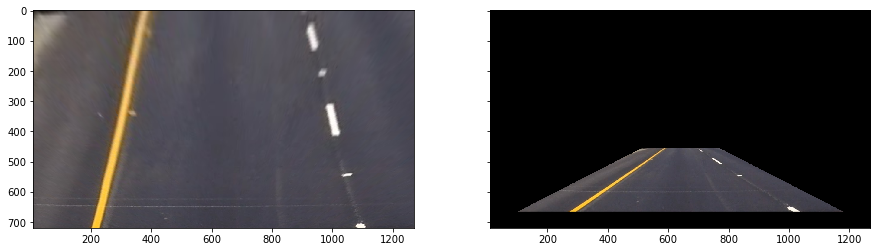

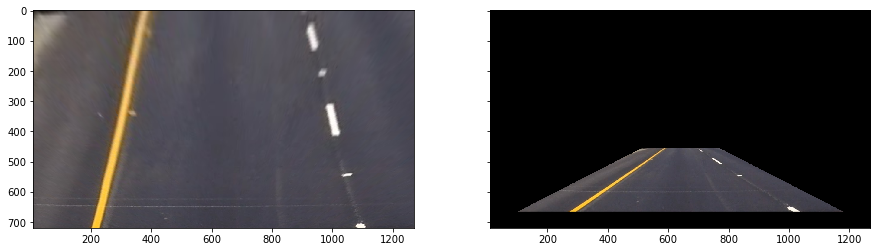

In [16]:
for filenmae in test_images:
    img=mpimg.imread(filenmae)    
    img_warp = perspective_transform(straight_line1_img,M)
    img_warp_inv = deperspective_transform(img_warp,MInv)

    f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
    f.set_size_inches([15., 4.])
    ax1.imshow(img_warp)
    binary_image=pipeline(img_warp,s_thresh=(255,0))

    ax2.imshow(img_warp_inv)
    plt.show()
    
    



   
    

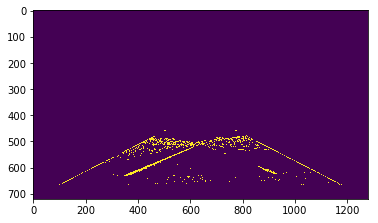

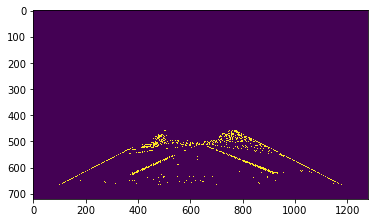

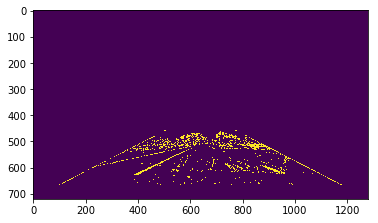

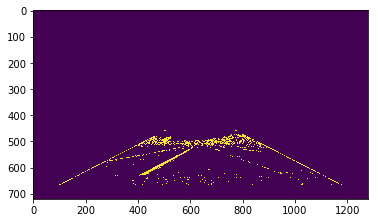

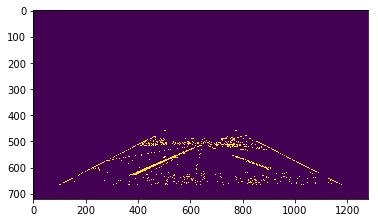

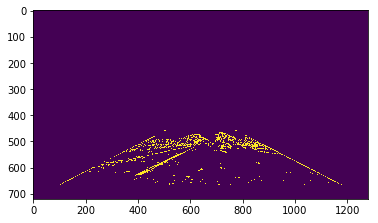

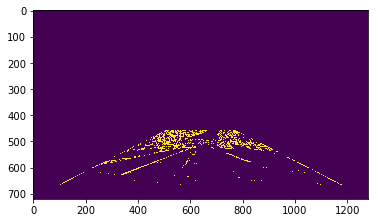

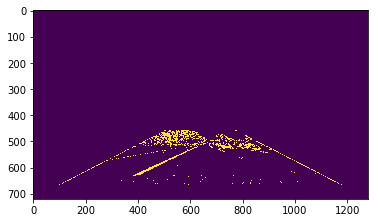

In [17]:
for filenmae in test_images:
    img=mpimg.imread(filenmae)    
    img_warp = perspective_transform(straight_line1_img,M)
    img_warp_inv = deperspective_transform(img_warp,MInv)
    
    
    detran=deperspective_transform(img,MInv)
    dd = pipeline(detran)
    color_warp = np.dstack((dd, dd, dd))
    result = cv2.addWeighted(img, 1, color_warp, 0.3, 0)
    plt.imshow(dd)
    plt.show()

## Find starting point through histogram

In [44]:
def find_line(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    global left_fit
    global right_fit

    #left_fit = None
    #right_fit = None
    smoothing=0.99
    if not 'left_fit' in globals():
        left_fit = np.polyfit(lefty, leftx, 2)
        print('left_fit == None')
    else:
        #print('smoothing===',smoothing)
        #print('left_fit===',left_fit)
        ##print('lefty===',lefty)
        #print('leftx===',leftx)
        if len(lefty)>0 and len(leftx)>=0:
            left_fit = (smoothing)*left_fit   + ((1-smoothing)*np.polyfit(lefty, leftx, 2))
    
    if not 'right_fit' in globals():
        right_fit = np.polyfit(righty, rightx, 2)
    else:
        right_fit = (smoothing)*right_fit + ((1-smoothing)*np.polyfit(righty, rightx, 2))


    smoothing=0.99
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
    except:
        pass
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    margin  *= 0.5
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 0,255))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,0,0))
    
    cv2.floodFill(image = window_img, seedPoint = (window_img.shape[1]//2-1,window_img.shape[0]-1), newVal=(0,255, 0), loDiff=(0, 0, 0, 0), upDiff=(0, 0, 0, 0), flags=4, mask=None)

    return left_fit,right_fit

In [45]:


def find_line_new(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 18
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

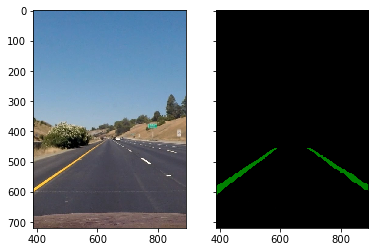

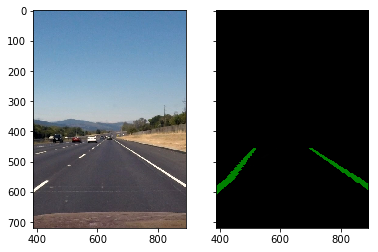

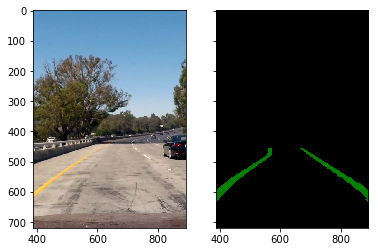

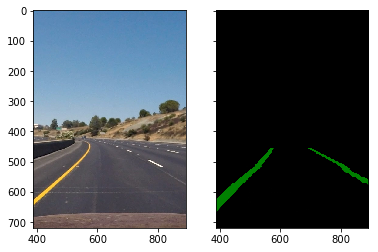

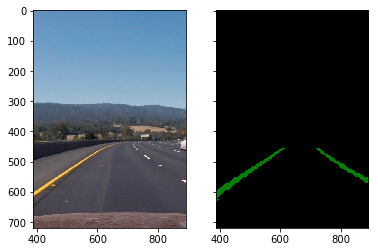

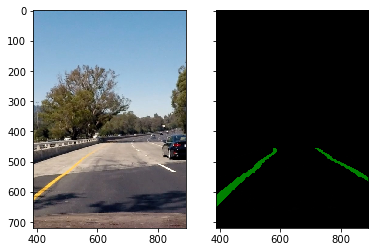

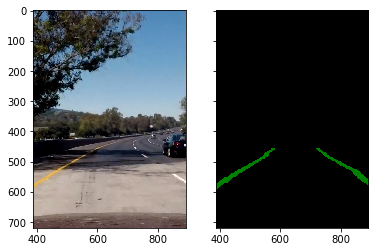

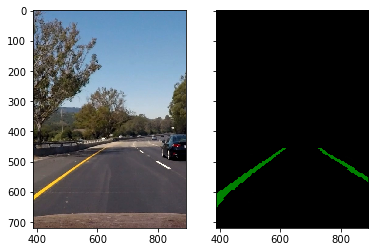

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2


def find_lane_windowed(warped):

    # window settings
    window_width = 60 
    window_height = 40 # Break image into 9 vertical layers since image height is 720
    margin = 15 # How much to slide left and right for searching

    def window_mask(width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def find_window_centroids(image, window_width, window_height, margin):

        window_centroids = [] # Store the (left,right) window centroid positions per level
        window = np.ones(window_width) # Create our window template that we will use for convolutions

        # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
        # and then np.convolve the vertical image slice with the window template 

        # Sum quarter bottom of image to get slice, could use a different ratio
        l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
        l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
        r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
        r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)

        # Add what we found for the first layer
        window_centroids.append((l_center,r_center))

        # Go through each layer looking for max pixel locations
        for level in range(1,(int)(warped.shape[0]/window_height)):
            # convolve the window into the vertical slice of the image
            image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            # Find the best left centroid by using past left center as a reference
            # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
            offset = window_width/2
            l_min_index = int(max(l_center+offset-margin,0))
            l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
            # Find the best right centroid by using past right center as a reference
            r_min_index = int(max(r_center+offset-margin,0))
            r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
            # Add what we found for that layer
            window_centroids.append((l_center,r_center))

        return window_centroids


    window_centroids = find_window_centroids(warped, window_width, window_height, margin)

    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results

    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    #plt.imshow(output)
    #plt.title('window fitting results')
    #plt.show()
    
    return output


def find_lane_windowed_test(path):
    orig_img=mpimg.imread(path)
    img=perspective_transform(orig_img,M)
    img = pipeline(img)
    img = find_lane_windowed(img)
    f, ( ax1,ax2) = plt.subplots(1, 2, sharey=True)
    ax1.imshow((orig_img))
    ax2.imshow(deperspective_transform(img,MInv))

    return img
    

for path in (test_images):
    find_lane_windowed_test(path)
 

In [47]:
binary_warped=binary_image
binary_warped.shape[0]/2
#binary_warped[binary_warped.shape[0]/2:,:]
#np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
left_fit,right_fit=find_line(binary_image)

In [49]:
def get_lines_points(binary_warped):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    return ploty, left_fitx,right_fitx


# Find polyfit

In [50]:
def fill_between_lanes(img,warped,left_fitx,right_fitx):
    ploty = np.linspace(0, warped.shape[0]-1, binary_warped.shape[0] )
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])

    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])


    pts = np.hstack((pts_left, pts_right))


    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInv, (straight_line1_img.shape[1], straight_line1_img.shape[0]))
    newwarp[:newwarp.shape[0]//4,:,:] = 0
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #plt.imshow(result)
    return result


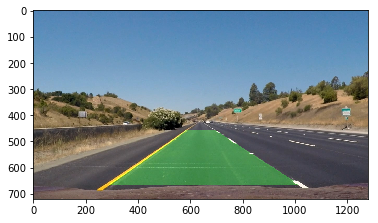

In [51]:

warped=binary_image
ploty, left_fitx,right_fitx=get_lines_points(warped)

result=fill_between_lanes(straight_line1_img,warped, left_fitx,right_fitx)
plt.imshow(result)
plt.show()

In [52]:
window_width = 40 
window_height = 250 # Break image into 9 vertical layers since image height is 720
margin = 50 # How much to slide left and right for searching

poly_left = []
poly_right = []

def get_curverad(coef, y):
    return ((1 + (2*coef[0]*y + coef[1])**2)**1.5) / np.abs(2*coef[0])


def process_image(img):
    global poly_left
    global poly_right
    #plt.plot(img)
    #plt.show()
    img_size = (img.shape[1], img.shape[0])
    # Undistort image
    undistorted = undistort_img(img,objpoints,imgpoints)

    #print(undistorted)
    # Warp image to bird eye view
    warped = perspective_transform(undistorted, M)
    #print(warped)
    #print('warped',warped)
  
    b_warped=pipeline(warped)
    #print('binary_warped',binary_warped)

    left_fit,right_fit=find_line(b_warped)
    #print('left_fit',left_fit)
    
    ploty, left_fitx,right_fitx=get_lines_points(b_warped)
    #print('left_fit',left_fitx)
    #print('left_fit',right_fitx)
    result=fill_between_lanes(img,b_warped, left_fitx,right_fitx)
    #plt.imshow(result)
    #plt.show()
    return result,undistorted,warped,b_warped

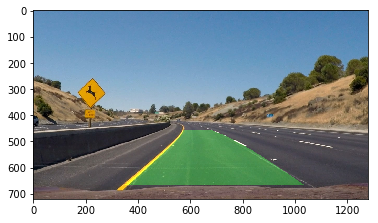

In [53]:
a=mpimg.imread('./test_images/test2.jpg')

result = process_image(mpimg.imread('./test_images/test2.jpg'))[0]
plt.imshow(result)
plt.show()

test_images/straight_lines1.jpg


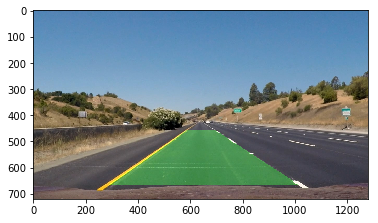

test_images/straight_lines2.jpg


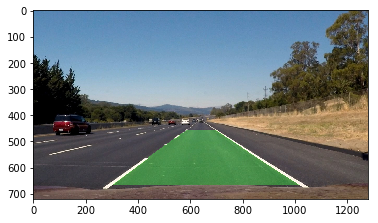

test_images/test1.jpg


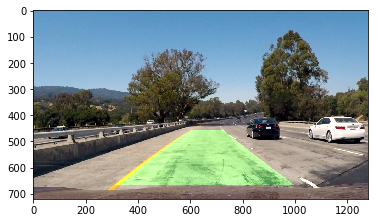

test_images/test2.jpg


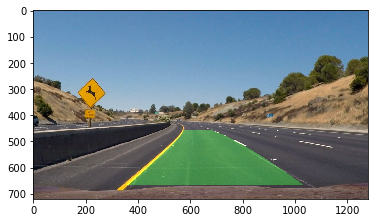

test_images/test3.jpg


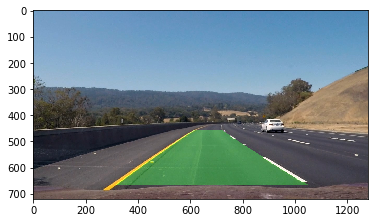

test_images/test4.jpg


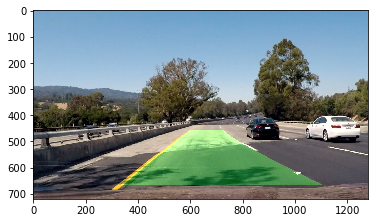

test_images/test5.jpg


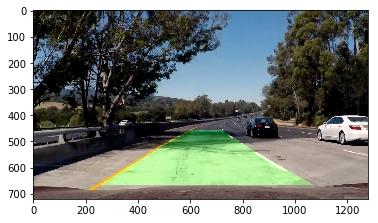

test_images/test6.jpg


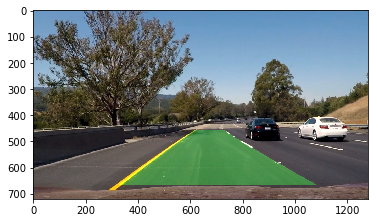

In [54]:

test_images = glob.glob('test_images/*.jpg')

for filenmae in test_images:
    print(filenmae)
    img=mpimg.imread(filenmae)    
    result,undistorted,warped,b_warped = process_image(img)
    plt.imshow(result)
    plt.show()
    #plt.imshow(undistorted)
    #plt.show()
    #plt.imshow(warped)
    #plt.show()
    #plt.imshow(b_warped)
    #plt.show()

In [55]:
import imageio
imageio.plugins.ffmpeg.download()


In [56]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'processed_video_project.mp4'

clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(lambda img: process_image(img)[0])
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video processed_video_project.mp4
[MoviePy] Writing video processed_video_project.mp4


100%|█████████▉| 1260/1261 [14:42<00:00,  1.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: processed_video_project.mp4 

CPU times: user 15min 3s, sys: 24.1 s, total: 15min 27s
Wall time: 14min 43s


In [57]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## And so on and so forth...